In [1]:
import geopandas as gpd
import pandas as pd
import h3pandas
import requests
import json
from matplotlib import pyplot as plt
from shapely.geometry import Point

In [2]:
COMMUNES_FILES = 'data/communes-martinique.geojson'

In [3]:
reload = False
if reload:
    # no need to share it, if you want it, you can get it
    with open ('/tmp/cliko.json') as r:
        j = json.load(r)
    latlon = []
    for jj in j['data']:
        if jj['clinic_zipcode'].startswith('972'):
            lon, lat = jj['clinic_longitude'], jj['clinic_latitude']
            if lon in ['0', ''] or lat in ['0', ''] or float(lat) < -20:
                continue
            latlon.append((float(lat), float(lon)))
    df = pd.DataFrame(data=latlon, columns=['lat', 'lon'])
    df.to_csv('data/cliko-latlon.json', index=False)
else:
    df = pd.read_csv('data/cliko-latlon.json')
gdf_cliko = gpd.GeoDataFrame(df)
gdf_cliko['geometry'] = gdf_cliko.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
gdf_cliko = gdf_cliko.set_crs('EPSG:4326')

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


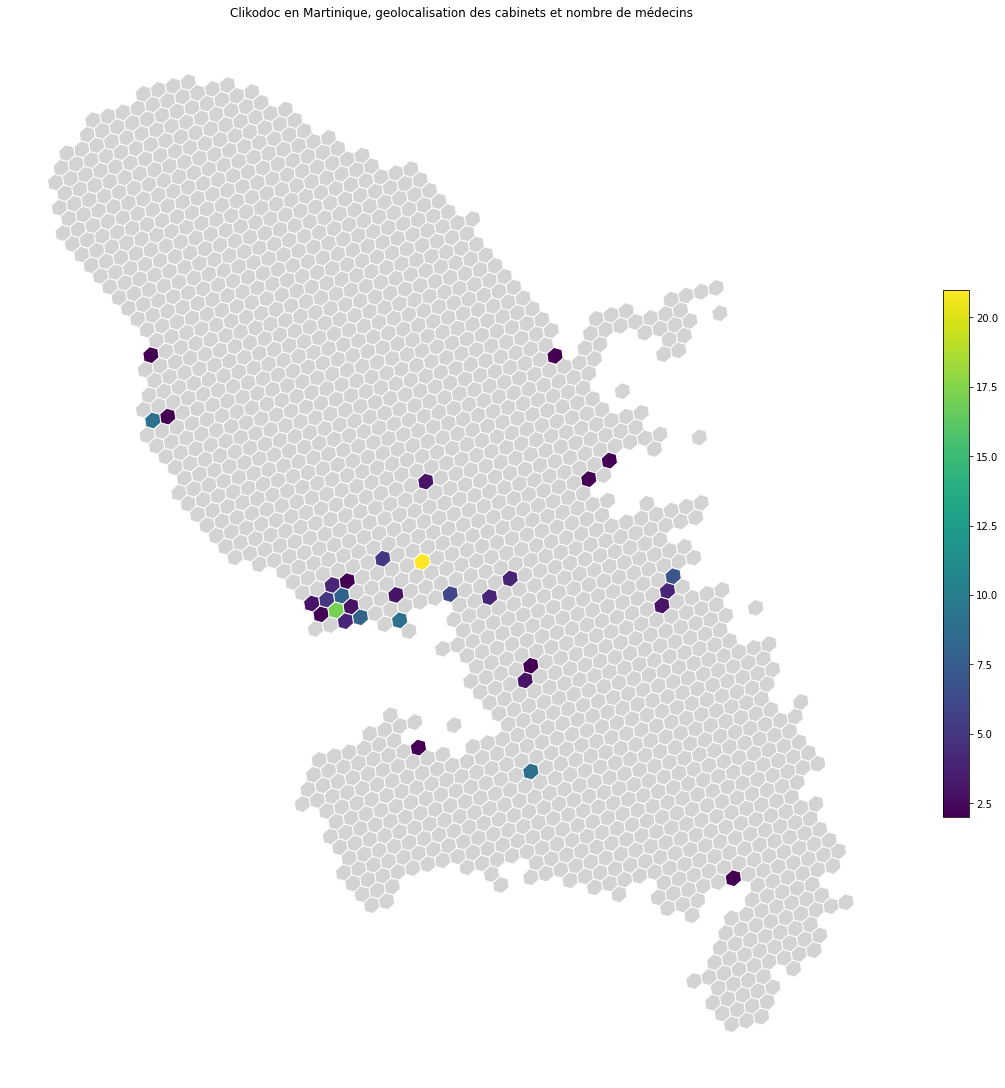

In [4]:
resolution = 8
gdf = gpd.read_file(COMMUNES_FILES)

# Resample to H3 cells
gdf = gdf.h3.polyfill_resample(resolution).drop(columns=['index']).reset_index()
gdf = gdf.merge(gpd.sjoin(gdf, gdf_cliko, how="right", predicate='intersects').groupby(by='h3_polyfill').agg(nb=('lat', 'size')).reset_index(), on='h3_polyfill', how='left').fillna(0)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 15))
fig.suptitle("Clikodoc en Martinique, geolocalisation des cabinets et nombre de médecins",
             backgroundcolor='white', color='black')

gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf.loc[gdf.nb >1].plot(ax=ax, edgecolor='white', column='nb', legend=True, legend_kwds={"shrink":0.5})
_ = ax.axis('off')

plt.savefig('output/2022-11-14.png', facecolor='white')